In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os 

from scipy.misc import imresize
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

import sys
sys.path.append('dcase2018_task4')

import Metrics
from Binarizer import *


/home/thomas/tools/miniconda2/envs/theanoEnvErebor/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import keras 

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from keras.models import model_from_json, load_model

# from keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
# from keras.applications.vgg19 import decode_predictions as vgg19_decode_predictions

from keras import optimizers
from keras.models import Model, Sequential
from keras.layers import Input, Dense, GlobalAveragePooling2D, GlobalMaxPooling2D, Lambda, \
    Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Activation, TimeDistributed, \
    GRU, Reshape, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, SpatialDropout2D, Concatenate
from keras import backend as K

import tensorflow as tf

In [3]:
K.set_image_data_format("channels_last")
K.image_data_format()

'channels_last'

In [4]:
K.clear_session()

# load data

In [5]:
from datasetGenerator import DCASE2018

In [6]:
metaRoot = '/baie/corpus/DCASE2018/task4/metadata'
featRoot = '/baie/corpus/DCASE2018/task4/FEATURES'
feat = ["mel"]
# feat = ["mel", "stack"]
normalizer=None
dataset = DCASE2018(
    featureRoot=featRoot,
    metaRoot=metaRoot,
    features=feat,
    validationPercent=0.2,
    normalizer=normalizer
)


mel


In [7]:
dataset.trainingDataset['mel']['input'].shape, dataset.validationDataset['mel']['input'].shape

((1768, 64, 431, 1), (435, 64, 431, 1))

In [8]:
x_train = dataset.trainingDataset['mel']['input']
# x_train = np.swapaxes(np.swapaxes(x_train,3,2), 2,1)
# x_train = np.tile(x_train, (1,3,1,1))

x_val = dataset.validationDataset['mel']['input']
# x_val = np.swapaxes(np.swapaxes(x_val,3,2), 2,1)
# x_val = np.tile(x_val, (1,3,1,1))

y_train = dataset.trainingDataset['mel']['output']
y_val = dataset.validationDataset['mel']['output']

x_train.shape, x_val.shape, y_train.shape, y_val.shape

((1768, 64, 431, 1), (435, 64, 431, 1), (1768, 10), (435, 10))

In [9]:
# concat train and val to get the final training data

final_x_train = np.concatenate((x_train, x_val), axis=0)
final_y_train = np.concatenate((y_train, y_val), axis=0)

final_x_train.shape, final_y_train.shape

((2203, 64, 431, 1), (2203, 10))

In [10]:
# Load the test data create the test dataset
# load the file list
featTestPath = featRoot + '/test/mel' 
featTestList = os.listdir(featTestPath)

# load the meta data ----
metaPath = metaRoot + "/test.csv"
with open(metaPath, "r") as metaFile:
    metadata = metaFile.read().splitlines()[1:]
    
metadata = [i.split("\t") for i in metadata]

# load the features
featTest = []
for file in featTestList:
    path = os.path.join(featTestPath, file)
    feature = np.load(path)
       
    # preprocessing
    feature = np.expand_dims(feature, axis=-1)
    featTest.append(feature)
    
featTest = np.array(featTest)

In [11]:
print(featTest.shape)
# featTest = np.swapaxes(np.swapaxes(featTest,3,2), 2,1)
# featTest = np.tile(featTest, (1,3,1,1))
# featTest.shape\

(279, 64, 431, 1)


In [12]:
# Which samples are Dishes?
class_index_dishes = DCASE2018.class_correspondance['Dishes']
samples_dishes_indices = np.where(y_train[:,class_index_dishes]==1)[0]

mask_ones_ten_for_dishes = np.ones([y_train.shape[0],])
mask_ones_ten_for_dishes[samples_dishes_indices] *= 10

samples_dishes_indices.shape, mask_ones_ten_for_dishes.shape, mask_ones_ten_for_dishes[samples_dishes_indices[0]]

((301,), (1768,), 10.0)

In [74]:
DCASE2018.class_correspondance

{'Alarm_bell_ringing': 0,
 'Blender': 8,
 'Cat': 3,
 'Dishes': 5,
 'Dog': 2,
 'Electric_shaver_toothbrush': 7,
 'Frying': 6,
 'Running_water': 9,
 'Speech': 1,
 'Vacuum_cleaner': 4}

# util functions

In [17]:
def load_model_from_h5(h5_model_path):
    return load_model(h5_model_path)

def load_model_from_json(jsonnom, wnom):
    with open(jsonnom, 'r') as fh:
# with open('dcase2018_task4/results/testing/dense_noTransfer_selu/dense_noTransfer_model.json', 'r') as fh:
        mo = model_from_json(fh.read())
        mo.load_weights(wnom)
    return mo

# gradient CAM function

In [16]:
# Define the function to compute the gradient at a given layer (layer_index)
def get_gCAM(model, layer_name, input_tensor_numpy, output_index=0, num2class_dico=None):
    
    doNormalizeGradients = False
#     K.set_learning_phase(0)
    
#     print(K.learning_phase())
    input_tensors = [model.input, # placeholder for input tensor
                     K.learning_phase(), # placeholder for mode (train or test) tense
                    ]
#     input_tensors = [model.input] # placeholder for input tensor

#     gradients = model.optimizer.get_gradients(model.output[0][output_index], model.input)
#     print(K.int_shape(model.output[0]))
    
#     layer_output = model.layers[layer_index].output
    layer_output = model.get_layer(layer_name).output
    print(K.int_shape(layer_output[0]))
    
    # compute the gradient wrt the output of the layer_name layer
    gradients = model.optimizer.get_gradients(model.output[0][output_index], layer_output)[0]

    if doNormalizeGradients:
        gradients = normalize(gradients)  
    
    print('gradient shape: ', K.int_shape(gradients))

    get_score_fn = K.function(inputs=input_tensors, outputs=[model.output[0][output_index]]) 
    score = get_score_fn([input_tensor_numpy, 0])[0]
#     score = get_score_fn(feed_dict={x: input_tensor_numpy, labels: batch[1], K.learning_phase(): 1})[0]
    print(score)

#     if num2class_dico is not None:
#         print('prob for class %i - %s: %.2f%%'%( output_index, num2class_dico[output_index], score*100))
#     else:
#         print('prob for class %i: %.2f%%'%( output_index, score*100))
    
#     compute_gradients_fn = K.function(inputs=input_tensors, outputs=[gradients])
    # Execute the function to compute the gradient
#     gradients = compute_gradients_fn([input_tensor_numpy])[0]
    
    # K.set_image_data_format('channels_last')
    if K.image_data_format() == 'channels_first':
        gap_gradients_coeffs = K.mean(gradients, axis=(2, 3))
    else:
        gap_gradients_coeffs = K.mean(gradients, axis=(1, 2))
        
    print('GAP gradient shape: ', K.int_shape(gap_gradients_coeffs))
    
    if K.image_data_format() == 'channels_first':
        grad_cam_map = K.expand_dims(K.expand_dims(gap_gradients_coeffs, axis=-1),  axis=-1) * layer_output
        grad_cam_map = K.sum(grad_cam_map[0], axis=0)
    else:
        grad_cam_map = K.expand_dims(K.expand_dims(gap_gradients_coeffs, axis=1),  axis=2) * layer_output
        grad_cam_map = K.sum(grad_cam_map[0], axis=-1)
    
    compute_gradCAM_fn = K.function(inputs=input_tensors, outputs=[grad_cam_map])
    
    grad_cam_map_numpy = compute_gradCAM_fn([input_tensor_numpy, 0])[0]
    print('grad_cam_map_numpy', grad_cam_map_numpy.shape)
    
    return grad_cam_map_numpy


# VGG

In [ ]:
useVGG19=False

if useVGG19:
    from keras.applications.vgg19 import preprocess_input, decode_predictions
    model = VGG19()
else:
    from keras.applications.vgg16 import preprocess_input, decode_predictions
    model = VGG16(include_top=False)

K.set_image_data_format('channels_last')
# K.set_image_data_format('channels_first')
print(K.image_data_format())

In [ ]:
model.summary()

In [ ]:
vgg_x_train = model.predict(x_train)
vgg_x_val = model.predict(x_val)

In [ ]:
vgg_x_train.shape, vgg_x_val.shape

In [ ]:
# last = model.output

# x = Flatten(input_shape=(512, 2, 13))(last)
# x = Dense(1024, activation='relu')(x)
# preds = Dense(10, activation='softmax')(x)

# dcase_model = Model(model.input, preds)

In [ ]:
dcase_model = Sequential()
dcase_model.add(Conv2D(128, 2, activation='relu', input_shape=(512, 2, 13)))
dcase_model.add(Dropout(0.5))
dcase_model.add(Flatten())
dcase_model.add(Dense(512, activation='relu'))
# dcase_model.add(Dropout(0.5))
dcase_model.add(Dense(10, activation='softmax'))
dcase_model.summary()

In [ ]:
# sgd = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-5, decay=0.0)
sgd = optimizers.Adam(lr=1e-4)

dcase_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
dcase_model.fit(vgg_x_train, y_train, validation_data=(vgg_x_val, y_val), epochs=10, batch_size=32)

In [ ]:
score = dcase_model.evaluate(vgg_x_val, y_val)
score

In [ ]:
prob = dcase_model.predict(vgg_x_val[0][np.newaxis])
pred = np.argmax(prob)
pred, prob[0][pred]

In [ ]:
gcam_heatmap = get_gCAM(dcase_model, layer_name='conv2d_13', input_tensor_numpy=vgg_x_val[0][np.newaxis], output_index=pred)

In [ ]:
vgg_x_val[0][np.newaxis].shape

In [ ]:
gcam_heatmap = imresize(gcam_heatmap, (224,10))
# cam = gcam_heatmap
gcam_heatmap = np.maximum(gcam_heatmap, 1e-5)
gcam_heatmap = gcam_heatmap / np.max(gcam_heatmap)

In [ ]:
gcam_heatmap_JET = plt.cm.jet(gcam_heatmap)
gcam_heatmap_JET = plt.cm.jet(gcam_heatmap)
# toto2_cm /= np.maximum(toto2_cm, 2)
plt.imshow(gcam_heatmap_JET[:,:,:3], cmap=cm.jet)
# plt.imshow(gcam_heatmap, cmap=cm.jet)
plt.colorbar()
gcam_heatmap_JET.shape, np.sum(gcam_heatmap_JET[:,:,0])

# My model

In [75]:
withGRU=False

melInput = Input(dataset.getInputShape("mel"))

# ---- mel convolution part ----
mBlock1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(melInput)
mBlock1 = BatchNormalization()(mBlock1)
mBlock1 = Activation(activation="relu")(mBlock1)
mBlock1 = MaxPooling2D(pool_size=(4, 2))(mBlock1)
mBlock1 = SpatialDropout2D(0.2, data_format=K.image_data_format())(mBlock1)

mBlock2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(mBlock1)
mBlock2 = BatchNormalization()(mBlock2)
mBlock2 = Activation(activation="relu")(mBlock2)
mBlock2 = MaxPooling2D(pool_size=(4, 1))(mBlock2)
mBlock2 = SpatialDropout2D(0.2, data_format=K.image_data_format())(mBlock2)

mBlock3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(mBlock2)
mBlock3 = BatchNormalization()(mBlock3)
mBlock3 = Activation(activation="relu")(mBlock3)
mBlock3 = MaxPooling2D(pool_size=(4, 1))(mBlock3)
mBlock3 = SpatialDropout2D(0.2, data_format=K.image_data_format())(mBlock3)

if withGRU:
    targetShape = int(mBlock3.shape[1] * mBlock3.shape[2])
    mReshape = Reshape(target_shape=(targetShape, 64))(mBlock3)

    gru = Bidirectional(
        GRU(kernel_initializer='glorot_uniform', activation='tanh', recurrent_dropout=0.1, dropout=0.1, units=64, return_sequences=True)
    )(mReshape)

    dense = TimeDistributed(
        Dense(64, activation="relu"),
    )(gru)

    output = TimeDistributed(
        Dense(dataset.nbClass, activation="sigmoid"),
    )(dense)

    output = GlobalAveragePooling1D()(output)
else:
    
    gap = GlobalAveragePooling2D()(mBlock3)
    gmp = GlobalMaxPooling2D()(mBlock3)
    # flat_gap = Flatten()(gap)
    # flat_gmp = Flatten()(gmp)
    
    concat = Concatenate()([gap, gmp])
    
    d = Dense(1024, activation="relu")(concat)
    d = Dropout(rate=0.5)(d)
    
    output = Dense(dataset.nbClass, activation="sigmoid")(d)
    

model1 = Model(inputs=[melInput], outputs=output)
model1.summary(line_length=100)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 64, 431, 1)    0                                            
____________________________________________________________________________________________________
conv2d_10 (Conv2D)               (None, 64, 431, 64)   640         input_4[0][0]                    
____________________________________________________________________________________________________
batch_normalization_10 (BatchNor (None, 64, 431, 64)   256         conv2d_10[0][0]                  
____________________________________________________________________________________________________
activation_10 (Activation)       (None, 64, 431, 64)   0           batch_normalization_10[0][0]     
___________________________________________________________________________________________

In [76]:
epochs = 100
batch_size = 32
metrics = ["accuracy", Metrics.f1, Metrics.recall, Metrics.precision]
loss = "binary_crossentropy"
optimizer = optimizers.Adam()
print("default lr: ", optimizer.lr)

default lr:  <tf.Variable 'Adam_4/lr:0' shape=() dtype=float32_ref>


In [77]:
def lrate_schedule_fn(epoch):
    if epoch < 30:
        # print('lr: 1e-3')
        return 1e-3
    elif epoch < 60:
        # print('lr: 1e-4')
        return 5e-4
    else:
        # print('lr: 1e-5')
        return 1e-4
lrate_scheduler = keras.callbacks.LearningRateScheduler(lrate_schedule_fn)

In [78]:
# weight dishes by a 10 factor

class_weight = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 10, 6: 1, 7: 1, 8: 1, 9: 1}

model1.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model1.fit(
    x=dataset.trainingDataset["mel"]["input"],
    y=dataset.trainingDataset["mel"]["output"],
    class_weight=class_weight,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(
        dataset.validationDataset["mel"]["input"],
        dataset.validationDataset["mel"]["output"]
    ),
    callbacks = [lrate_scheduler],
    verbose=1
)


Train on 1768 samples, validate on 435 samples
Epoch 1/100
1768/1768 [==============================] - 7s - loss: 0.7596 - acc: 0.7895 - f1: 0.1909 - recall: 0.1577 - precision: 0.2649 - val_loss: 0.6964 - val_acc: 0.7611 - val_f1: 0.1215 - val_recall: 0.0913 - val_precision: 0.1820
Epoch 2/100
1768/1768 [==============================] - 6s - loss: 0.5951 - acc: 0.8107 - f1: 0.1933 - recall: 0.1418 - precision: 0.3193 - val_loss: 0.4397 - val_acc: 0.8198 - val_f1: 0.0264 - val_recall: 0.0137 - val_precision: 0.4536
Epoch 3/100
1768/1768 [==============================] - 6s - loss: 0.5634 - acc: 0.8190 - f1: 0.2139 - recall: 0.1533 - precision: 0.3657 - val_loss: 0.3939 - val_acc: 0.8324 - val_f1: 0.2036 - val_recall: 0.1188 - val_precision: 0.7601
Epoch 4/100
1768/1768 [==============================] - 6s - loss: 0.5352 - acc: 0.8270 - f1: 0.2627 - recall: 0.1926 - precision: 0.4264 - val_loss: 0.3980 - val_acc: 0.8370 - val_f1: 0.2910 - val_recall: 0.1858 - val_precision: 0.6873
E

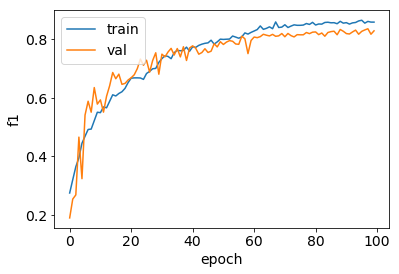

In [56]:
# # summarize history for accuracy
# plt.plot(model1.history.history['acc'])
# plt.plot(model1.history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(model1.history.history['loss'])
# plt.plot(model1.history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# summarize history for lf1
fig = plt.figure()
plot = fig.add_subplot(111)

plt.plot(model1.history.history['f1'])
plt.plot(model1.history.history['val_f1'])
# plt.title('f1')
plt.ylabel('f1', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.legend(['train', 'val'], loc='upper left', fontsize=14)
plt.tick_params(labelsize = 14)
# plt.show()
plt.savefig('thomas_models/classif_cnn_100epochs_f1_%.4f_valf1_%.4f_losses.png'%(model1.history.history['f1'][-1], model1.history.history['val_f1'][-1]))

# plt.plot(model1.history.history['precision'])
# plt.plot(model1.history.history['val_precision'])
# plt.ylabel('precision')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

# plt.plot(model1.history.history['recall'])
# plt.plot(model1.history.history['val_recall'])
# plt.ylabel('recall')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()


# model1.history.history.keys()

In [54]:
print('f1_%.4f'%model1.history.history['f1'][-1])

f1_0.8584


In [55]:
model1.save('thomas_models/classif_cnn_100epochs_f1_%.4f_valf1_%.4f.h5'%(model1.history.history['f1'][-1], model1.history.history['val_f1'][-1]))

In [25]:
def lrate_schedule_fn(epoch):
    if epoch < 30:
        # print('lr: 1e-3')
        return 1e-3
    elif epoch < 50:
        # print('lr: 1e-4')
        return 1e-4
    else:
        # print('lr: 1e-5')
        return 1e-5
lrate_scheduler = keras.callbacks.LearningRateScheduler(lrate_schedule_fn)


In [95]:
epochs = 70
batch_size = 32
metrics = ["accuracy", Metrics.f1, Metrics.recall, Metrics.precision]
loss = "binary_crossentropy"
optimizer = optimizers.Adam()

final_model = Model(inputs=[melInput], outputs=output)
final_model.summary(line_length=100)

final_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
final_model.fit(
    x=final_x_train,
    y=final_y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(
        dataset.validationDataset["mel"]["input"],
        dataset.validationDataset["mel"]["output"]
    ),
    callbacks = [lrate_scheduler],
    verbose=1
)


____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
input_1 (InputLayer)                         (None, 64, 431, 1)                      0              
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                            (None, 64, 431, 64)                     640            
____________________________________________________________________________________________________
batch_normalization_1 (BatchNormalization)   (None, 64, 431, 64)                     256            
____________________________________________________________________________________________________
activation_1 (Activation)                    (None, 64, 431, 64)                     0              
___________________________________________________________________________________________

In [96]:
final_model.save('thomas_models/classif_cnn_70epochs_final_xtrain_f1_0.8762.h5')

In [27]:
# model2 = load_model('thomas_models/classif_cnn_70epochs_final_xtrain_f1_0.8762.h5', 
#                             custom_objects={'f1': Metrics.f1, 'recall': Metrics.recall, 
#                                             'precision': Metrics.precision})

model2 = load_model('thomas_models/classif_cnn_100epochs_f1_0.8584_valf1_0.8286.h5', 
                            custom_objects={'f1': Metrics.f1, 'recall': Metrics.recall, 
                                            'precision': Metrics.precision})

In [28]:
model2.summary(line_length=100)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_10 (InputLayer)            (None, 64, 431, 1)    0                                            
____________________________________________________________________________________________________
conv2d_28 (Conv2D)               (None, 64, 431, 64)   640         input_10[0][0]                   
____________________________________________________________________________________________________
batch_normalization_28 (BatchNor (None, 64, 431, 64)   256         conv2d_28[0][0]                  
____________________________________________________________________________________________________
activation_28 (Activation)       (None, 64, 431, 64)   0           batch_normalization_28[0][0]     
___________________________________________________________________________________________

In [29]:
binarizer = Binarizer()
binarizer.thresholds = dict()
# binarizer.reset() # met tous les seuils a 0.5
# binarizer.thresholds=[0.5]*10
for key in DCASE2018.class_correspondance:
    binarizer.thresholds[key] = 0.5
    
prediction = model2.predict(dataset.validationDataset["mel"]["input"])

binPrediction = binarizer.binarize(prediction)
f1_avant = f1_score(dataset.validationDataset[feat[0]]["output"], binPrediction, average=None)

binarizer.optimize(dataset.validationDataset["mel"]["output"], prediction)
binPrediction = binarizer.binarize(prediction)

f1 = f1_score(dataset.validationDataset[feat[0]]["output"], binPrediction, average=None)

In [30]:
binarizer.thresholds

{'Alarm_bell_ringing': 0.6533722163471876,
 'Blender': 0.477591783651769,
 'Cat': 0.38196065755828584,
 'Dishes': 0.3479929351334859,
 'Dog': 0.6408947243468816,
 'Electric_shaver_toothbrush': 0.5902707770871404,
 'Frying': 0.36402404542238614,
 'Running_water': 0.36065767792993303,
 'Speech': 0.43343696001778403,
 'Vacuum_cleaner': 0.34219562365139106}

In [31]:
f1_avant, f1

(array([0.86956522, 0.8852459 , 0.81481481, 0.8490566 , 0.63157895,
        0.8       , 0.8172043 , 0.74285714, 0.69565217, 0.76363636]),
 array([0.86956522, 0.89587426, 0.83211679, 0.84      , 0.75362319,
        0.7607362 , 0.82524272, 0.74285714, 0.69767442, 0.83969466]))

In [36]:
# indice = featTestList.index('Y0eh_N-cmcuI_350.000_360.000.wav.npy')
indice = 7
toto = model2.predict(featTest[indice][np.newaxis])
binPrediction = binarizer.binarize(toto)

fichier_id=featTestList[indice].replace('.wav.npy', '')
indice, fichier_id, toto.shape, toto, DCASE2018.class_correspondance_reverse[np.argmax(toto)], binPrediction

(7,
 'YnsxAMfzY_Wo_160.000_170.000',
 (1, 10),
 array([[9.8617435e-01, 9.9878967e-01, 1.7697931e-03, 9.1165146e-03,
         1.9031903e-04, 1.0680790e-03, 5.0748704e-04, 2.7717266e-04,
         1.6050024e-02, 5.8766716e-04]], dtype=float32),
 'Speech',
 array([[1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32))

In [32]:
all_eval_probs = model2.predict(featTest)
all_eval_preds = binarizer.binarize(all_eval_probs)

all_eval_probs.shape, all_eval_preds.shape, all_eval_probs[4], all_eval_preds[:10]

((279, 10),
 (279, 10),
 array([6.3309260e-02, 8.9313978e-01, 9.8151934e-01, 1.2152948e-04,
        3.2896633e-04, 1.5907063e-03, 3.4260811e-05, 8.5837010e-04,
        2.0286101e-03, 8.6328341e-03], dtype=float32),
 array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32))

In [31]:
DCASE2018.class_correspondance_reverse

{0: 'Alarm_bell_ringing',
 1: 'Speech',
 2: 'Dog',
 3: 'Cat',
 4: 'Vacuum_cleaner',
 5: 'Dishes',
 6: 'Frying',
 7: 'Electric_shaver_toothbrush',
 8: 'Blender',
 9: 'Running_water'}

In [33]:
for i in range(10):
    print(i, featTestList[i].replace('.npy', ''))

0 Y0UN02RkbG_U_7.000_17.000.wav
1 Y-6-rh8kbZf0_40.000_50.000.wav
2 Y6ocUrRBIuls_340.000_350.000.wav
3 Y7wPIQMsalK8_70.000_80.000.wav
4 Y-dDpGRPHzM0_30.000_40.000.wav
5 Y97oxHi3qxs8_0.000_10.000.wav
6 Y57wLY6lcZus_80.000_90.000.wav
7 YnsxAMfzY_Wo_160.000_170.000.wav
8 Yi7VpXVrrTPs_30.000_40.000.wav
9 Y7HSpbwWrii0_10.000_20.000.wav


# Leo's models

In [ ]:
model_dir='dcase2018_task4/models/'

model = load_model(model_dir + 'newMel_monoLabel_model.json', model_dir + 'newMel_monoLabel_weight.h5py')


In [ ]:
model.summary()
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# heat map

In [28]:
indice = 2
prob = model.predict(featTest[indice][np.newaxis])
print(prob)
pred = np.argmax(prob)
featTestList[indice], pred, prob[0][pred], DCASE2018.class_correspondance_reverse[pred]

[[1.8274756e-04 9.9162358e-01 1.9137383e-03 7.6861214e-04 2.1298030e-01
  3.3102676e-02 1.3320468e-01 3.5192645e-03 7.5232017e-01 4.9261190e-02]]


('Y6ocUrRBIuls_340.000_350.000.wav.npy', 1, 0.9916236, 'Speech')

In [35]:
DCASE2018.class_correspondance_reverse

{0: 'Alarm_bell_ringing',
 1: 'Speech',
 2: 'Dog',
 3: 'Cat',
 4: 'Vacuum_cleaner',
 5: 'Dishes',
 6: 'Frying',
 7: 'Electric_shaver_toothbrush',
 8: 'Blender',
 9: 'Running_water'}

In [36]:
binarizer.binarize(prob)

array([[0., 1., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [143]:
# gcam_heatmap = get_gCAM(model, 
#                         layer_name='activation_1', 
#                         input_tensor_numpy=featTest[indice][np.newaxis],
#                         output_index=1,
#                         num2class_dico=DCASE2018.class_correspondance_reverse)

gcam_heatmap = get_gCAM(model, 
                        layer_name='activation_3', 
                        input_tensor_numpy=toto2[np.newaxis,:,:,np.newaxis],
                        output_index=4,
                        num2class_dico=DCASE2018.class_correspondance_reverse)

(4, 431, 64)
gradient shape:  (None, 4, 431, 64)
0.5866375
GAP gradient shape:  (None, 64)
grad_cam_map_numpy (4, 431)


In [144]:
gcam_heatmap = imresize(gcam_heatmap, (64,431))
# cam = gcam_heatmap
# gcam_heatmap = np.maximum(gcam_heatmap, 1e-5)
# gcam_heatmap = gcam_heatmap / np.max(gcam_heatmap)

/home/thomas/tools/miniconda2/envs/theanoEnvErebor/lib/python3.5/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/thomas/tools/miniconda2/envs/theanoEnvErebor/lib/python3.5/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


((64, 431, 4), 12096.72342015985)

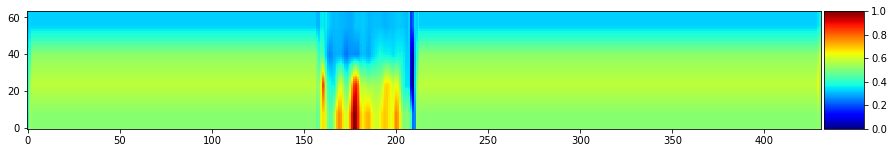

In [145]:
gcam_heatmap_JET = plt.cm.jet(gcam_heatmap)
plt.figure(figsize=(15,15))
ax = plt.gca()
# toto2_cm /= np.maximum(toto2_cm, 2)
im = ax.imshow(gcam_heatmap_JET[:,:,:3], cmap=cm.jet, origin='lower')
# plt.imshow(gcam_heatmap, cmap=cm.jet)
# plt.colorbar()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
gcam_heatmap_JET.shape, np.sum(gcam_heatmap_JET[:,:,0])


/home/thomas/tools/miniconda2/envs/theanoEnvErebor/lib/python3.5/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


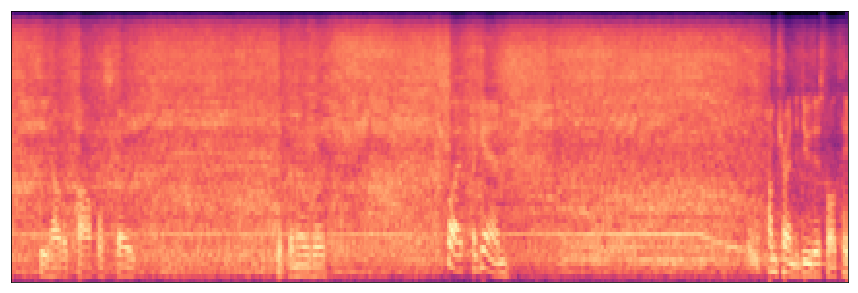

In [77]:
import librosa.display
plt.figure(figsize=(15,5))
librosa.display.specshow(featTest[indice][:,:,0])
# plt.imshow(featTest[indice][:,:,0], origin='lower')

In [78]:
featTest[indice].shape

(64, 431, 1)

In [358]:
toto = np.squeeze(featTest[indice])
toto.shape, indice

((64, 431), 91)

In [98]:
toto2 = np.copy(toto)
toto2[:,200:]=0

/home/thomas/tools/miniconda2/envs/theanoEnvErebor/lib/python3.5/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


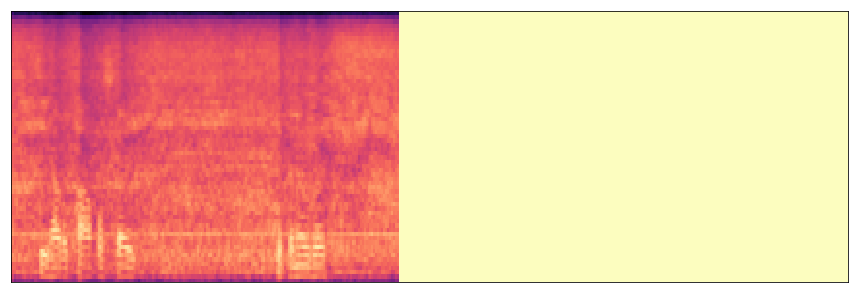

In [99]:
plt.figure(figsize=(15,5))
librosa.display.specshow(toto2)

In [136]:
prob = model.predict(toto2[np.newaxis,:,:,np.newaxis])
bin_preds = binarizer.binarize(prob)
[print(i, DCASE2018.class_correspondance_reverse[i]) for i in range(10) if bin_preds[0, i]>0]

4 Vacuum_cleaner


[None]

In [356]:
i=16
toto2 = np.copy(toto)
toto2[:, :i*10]=0
toto2[:, i*10+50:]=0


/home/thomas/tools/miniconda2/envs/theanoEnvErebor/lib/python3.5/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


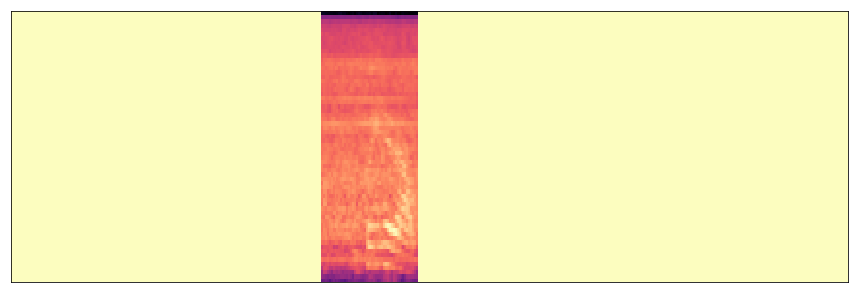

In [357]:
plt.figure(figsize=(15,5))
librosa.display.specshow(toto2)

# multiinstance training

In [146]:
K.clear_session()

In [39]:
melInput = Input(dataset.getInputShape("mel"))

# ---- mel convolution part ----
mBlock1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(melInput)
mBlock1 = BatchNormalization()(mBlock1)
mBlock1 = Activation(activation="relu")(mBlock1)
mBlock1 = MaxPooling2D(pool_size=(4, 1))(mBlock1)
mBlock1 = SpatialDropout2D(0.3, data_format=K.image_data_format())(mBlock1)

mBlock2 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(mBlock1)
mBlock2 = BatchNormalization()(mBlock2)
mBlock2 = Activation(activation="relu")(mBlock2)
mBlock2 = MaxPooling2D(pool_size=(4, 1))(mBlock2)
mBlock2 = SpatialDropout2D(0.3, data_format=K.image_data_format())(mBlock2)

mBlock3 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(mBlock2)
mBlock3 = BatchNormalization()(mBlock3)
mBlock3 = Activation(activation="relu")(mBlock3)
mBlock3 = MaxPooling2D(pool_size=(4, 1))(mBlock3)
mBlock3 = SpatialDropout2D(0.3, data_format=K.image_data_format())(mBlock3)

targetShape = int(mBlock3.shape[1] * mBlock3.shape[2])
mReshape = Reshape(target_shape=(targetShape, 64))(mBlock3)

gru = Bidirectional(
    GRU(kernel_initializer='glorot_uniform', activation='tanh', recurrent_dropout=0.1, \
        dropout=0.1, units=64, return_sequences=True)
)(mReshape)

output = TimeDistributed(
    Dense(64, activation="relu"),
)(gru)

output = TimeDistributed(
    Dense(dataset.nbClass, activation="sigmoid"),
)(output)


# output = GlobalAveragePooling1D()(output)

model = Model(inputs=[melInput], outputs=output)
model.summary(line_length=100)


____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
input_3 (InputLayer)                         (None, 64, 431, 1)                      0              
____________________________________________________________________________________________________
conv2d_7 (Conv2D)                            (None, 64, 431, 64)                     640            
____________________________________________________________________________________________________
batch_normalization_7 (BatchNormalization)   (None, 64, 431, 64)                     256            
____________________________________________________________________________________________________
activation_7 (Activation)                    (None, 64, 431, 64)                     0              
___________________________________________________________________________________________

In [15]:
def MIL_loss(y_true, y_pred):
    """
    multi-instance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    
    max_y_pred = K.max(y_pred, axis=1, keepdims=False)
    print(K.int_shape(max_y_pred))
    print(K.int_shape(y_true[:,0,:]))
    max_loss_ = K.binary_crossentropy(y_true[:,0,:], max_y_pred) 
    mean_loss_ = K.binary_crossentropy(y_true[:,0,:]/2, K.mean(y_pred, axis=1, keepdims=False)) 
    min_loss_ = K.binary_crossentropy(y_true[:,0,:]*0, K.min(y_pred, axis=1, keepdims=False)) 
    
    return max_loss_ + mean_loss_ + min_loss_


In [40]:
epochs = 50
batch_size = 32
# metrics = ["accuracy"]
optimizer = optimizers.Adam()

model.compile(loss=MIL_loss, optimizer=optimizer)

(None, 10)
(None, None)


In [41]:
dataset.trainingDataset["mel"]["output"].shape, dataset.trainingDataset["mel"]["output"][:, np.newaxis,:].shape

((1768, 10), (1768, 1, 10))

In [42]:
def lrate_schedule_fn(epoch):
    if epoch < 30:
        #print('lr: 1e-4')
        return 1e-4
    elif epoch < 50:
        #print('lr: 5e-5')
        return 5e-5
    else:
        # print('lr: 1e-6')
        return 1e-6


In [43]:
lrate_scheduler = keras.callbacks.LearningRateScheduler(lrate_schedule_fn)

history = model.fit(
    x=dataset.trainingDataset["mel"]["input"],
    y=dataset.trainingDataset["mel"]["output"][:, np.newaxis,:],
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(
        dataset.validationDataset["mel"]["input"],
        dataset.validationDataset["mel"]["output"][:, np.newaxis,:]
    ),
    callbacks=[lrate_scheduler],
    verbose=1
)

Train on 1768 samples, validate on 435 samples
Epoch 1/50
1768/1768 [==============================] - 69s - loss: 1.6162 - val_loss: 1.3878
Epoch 2/50
1768/1768 [==============================] - 70s - loss: 0.9425 - val_loss: 0.8404
Epoch 3/50
1768/1768 [==============================] - 68s - loss: 0.7566 - val_loss: 0.7625
Epoch 4/50
1768/1768 [==============================] - 69s - loss: 0.7222 - val_loss: 0.7502
Epoch 5/50
1768/1768 [==============================] - 68s - loss: 0.7133 - val_loss: 0.7433
Epoch 6/50
1768/1768 [==============================] - 68s - loss: 0.7057 - val_loss: 0.7352
Epoch 7/50
1768/1768 [==============================] - 69s - loss: 0.6989 - val_loss: 0.7182
Epoch 8/50
1768/1768 [==============================] - 69s - loss: 0.6875 - val_loss: 0.7028
Epoch 9/50
1768/1768 [==============================] - 68s - loss: 0.6840 - val_loss: 0.6922
Epoch 10/50
1768/1768 [==============================] - 68s - loss: 0.6736 - val_loss: 0.6848
Epoch 11/50


In [45]:
model.save('thomas_models/MIL_27juillet.h5')

In [80]:
# model = load_model('thomas_models/100epochs_MIL_cnn.h5', custom_objects={'MIL_loss': MIL_loss})
model = load_model('thomas_models/10epochs_MIL_cnn.h5', custom_objects={'MIL_loss': MIL_loss, 'f1': Metrics.f1, 'recall': Metrics.recall, 
                                            'precision': Metrics.precision})
model.summary()

(None, 10)
(None, None)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 431, 1)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 431, 64)       640       
_________________________________________________________________
batch_normalization_4 (Batch (None, 64, 431, 64)       256       
_________________________________________________________________
activation_4 (Activation)    (None, 64, 431, 64)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 431, 64)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 431, 64)       36928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 431, 64)    

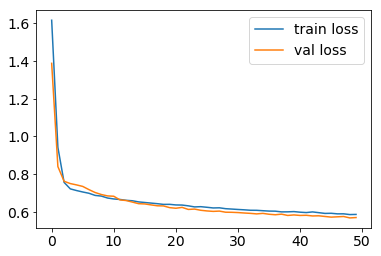

In [46]:
fig = plt.figure()
plot = fig.add_subplot(111)

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'],  label='val loss')
plt.legend(fontsize=14)

# We change the fontsize of minor ticks label 
plt.tick_params(labelsize = 14)
# plt.savefig('thomas_models/100epochs_MIL_cnn_losses_train_0.126_val_0.186.png')

In [47]:
history.history['loss'][-1], history.history['val_loss'][-1]

(0.5867016844080584, 0.5701081169062647)

In [48]:
all_eval_strong_probs = model.predict(featTest)
all_eval_strong_probs.shape

(279, 431, 10)

In [57]:
# np.savez('pour_patrice/all_eval_strong_probs.npz', courbes=all_eval_strong_probs)

In [24]:
def rescale(array_1d):
    """rescale between 0 and 1 a 1d-array"""
    return (array_1d - np.min(array_1d[3:-3])) / (np.max(array_1d[3:-3]) - np.min(array_1d[3:-3]))
    
def get_prob_curves_for_predicted_classes(class_preds, probs_3d, featTestList, int2className):
    dico_prob_curves_for_predicted_classes = {}
    for i, fileid in enumerate(featTestList):
        fileid_short = fileid.replace(".wav.npy", "")
        dico_prob_curves_for_predicted_classes[fileid_short] = {}
        current_classes = np.nonzero(class_preds[i])[0]
        for j in range(current_classes.shape[0]):
            class_name = int2className[current_classes[j]]
            dico_prob_curves_for_predicted_classes[fileid_short][class_name] = rescale(probs_3d[i,:,current_classes[j]])
    
    return dico_prob_curves_for_predicted_classes


def get_prob_curves_for_all_classes(probs_3d, featTestList, int2className):
    dico_prob_curves_for_all_classes = {}
    for i, fileid in enumerate(featTestList):
        fileid_short = fileid.replace(".wav.npy", "")
        dico_prob_curves_for_all_classes[fileid_short] = {}
        for j in range(10):
            class_name = int2className[j]
            dico_prob_curves_for_all_classes[fileid_short][class_name] = rescale(probs_3d[i,:,j])
    
    return dico_prob_curves_for_all_classes

In [49]:
dico_prob_curves_for_predicted_classes = get_prob_curves_for_predicted_classes(all_eval_preds, 
                                                                               all_eval_strong_probs, 
                                                                               featTestList, 
                                                                               DCASE2018.class_correspondance_reverse)

In [91]:
# dico_prob_curves_for_all_classes = get_prob_curves_for_all_classes(all_eval_strong_probs, 
#                                                                                featTestList, 
#                                                                                DCASE2018.class_correspondance_reverse)

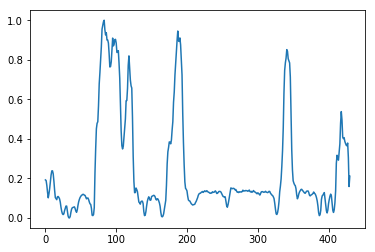

In [50]:
toto = dico_prob_curves_for_predicted_classes['Y0UN02RkbG_U_7.000_17.000']['Cat']
plt.plot(toto)

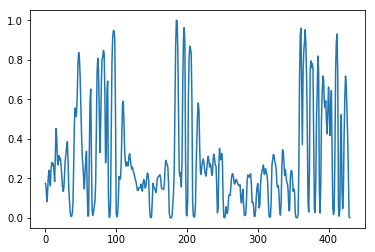

In [51]:
toto = dico_prob_curves_for_predicted_classes['Y-dDpGRPHzM0_30.000_40.000']['Speech']
plt.plot(toto)

Dog
Speech


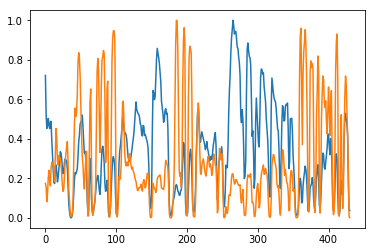

In [52]:
toto = dico_prob_curves_for_predicted_classes['Y-dDpGRPHzM0_30.000_40.000']
for k in toto.keys():
    print(k)
    plt.plot(toto[k])
# plt.plot(toto)

In [37]:
import pickle

def save_obj(obj, name ):
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name, 'rb') as f:
        return pickle.load(f)

In [53]:
# classif_cnn_step1_name = 'classif_cnn_100epochs_f1_%.4f_valf1_%.4f'%(model1.history.history['f1'][-1], model1.history.history['val_f1'][-1])
classif_cnn_step1_name = 'classif_cnn_100epochs_f1_0.8584_valf1_0.8286'
# classif_cnn_step1_name = 'classif_cnn_70epochs_final_xtrain_f1_0.8762'

save_obj(dico_prob_curves_for_predicted_classes, "eval_predictions/dico_10epochs_MIL_1024_cnn_%s.pkl"%classif_cnn_step1_name )

In [92]:
# pour Patrice
# save_obj(dico_prob_curves_for_all_classes, "eval_predictions/dico_10epochs_MIL_cnn_all_classes.pkl" )

In [76]:
# dico_toto = load_obj("eval_predictions/dico_10epochs_MIL_cnn_%s.pkl"%classif_cnn_step1_name )

dico_toto = load_obj("eval_predictions/dico_10epochs_MIL_cnn_classif_cnn_100epochs_f1_0.8584_valf1_0.8286.pkl")

Speech
Dog


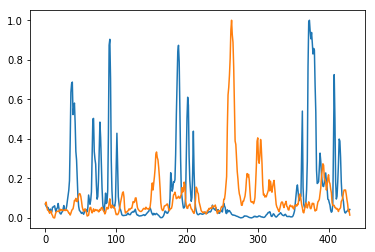

In [77]:
toto = dico_toto['Y-dDpGRPHzM0_30.000_40.000']
for k in toto.keys():
    print(k)
    plt.plot(toto[k])
# plt.plot(toto)

In [241]:
DCASE2018.class_correspondance_reverse

{0: 'Alarm_bell_ringing',
 1: 'Speech',
 2: 'Dog',
 3: 'Cat',
 4: 'Vacuum_cleaner',
 5: 'Dishes',
 6: 'Frying',
 7: 'Electric_shaver_toothbrush',
 8: 'Blender',
 9: 'Running_water'}

In [335]:
DCASE2018.class_correspondance

{'Alarm_bell_ringing': 0,
 'Blender': 8,
 'Cat': 3,
 'Dishes': 5,
 'Dog': 2,
 'Electric_shaver_toothbrush': 7,
 'Frying': 6,
 'Running_water': 9,
 'Speech': 1,
 'Vacuum_cleaner': 4}

In [450]:
featTestList.index('Y1-0EYLUEbRo_340.000_350.000.wav.npy')

83

In [93]:
# indice = 78
indice = 4
prob = model.predict(featTest[indice][np.newaxis])
fichier_id=featTestList[indice].replace('.wav.npy', '')
fichier_id, prob.shape, prob[0,:,1].shape, np.mean(prob[0], axis=0)

('Y-dDpGRPHzM0_30.000_40.000',
 (1, 431, 10),
 (431,),
 array([0.03158931, 0.12954304, 0.06614874, 0.03214392, 0.02864471,
        0.0420122 , 0.01843305, 0.02405359, 0.02534929, 0.0472401 ],
       dtype=float32))

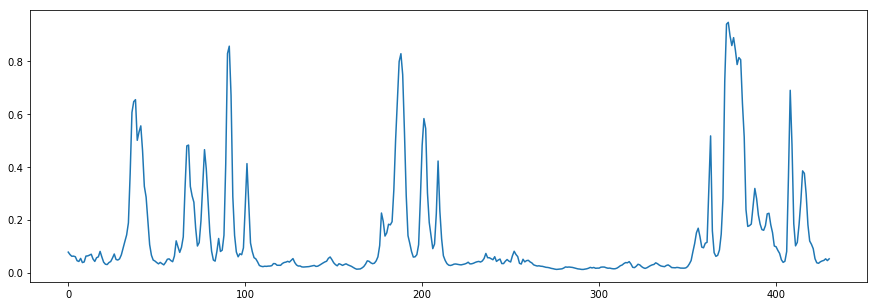

In [94]:
plt.figure(figsize=(15,5))
plt.plot(prob[0,:,1])


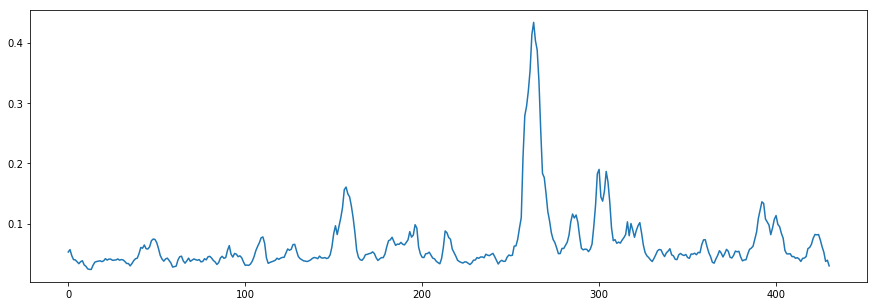

In [95]:
plt.figure(figsize=(15,5))
plt.plot(prob[0,:,2])


NameError: name 'librosa' is not defined

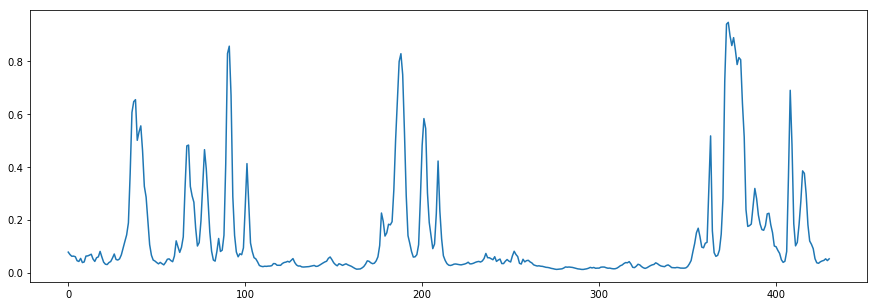

In [76]:
plt.figure(figsize=(15,5))
plt.plot(prob[0,:,1])
librosa.display.specshow(featTest[indice][:,:,0])
# plt.imshow(featTest[indice][:,:,0], alpha=0.5)

1.0
1.0


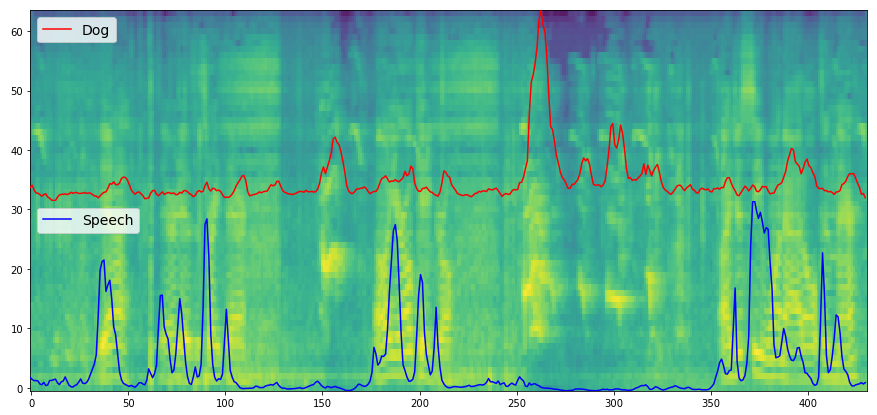

In [96]:
indice=4
fig, axs = plt.subplots(1,1,figsize=(15,7))

# axs.imshow(featTest[indice][:,:,0] , cmap='gray', interpolation='none', alpha=0.3)
axs.imshow(featTest[indice][:,:,0], origin='lower', interpolation='none', aspect='auto', alpha=0.9)

nplots = 2

dico={0: 1, 1: 2}
dico_c={0: 'b', 1: 'r'}
dico_l={0: 'Speech', 1: 'Dog'}

# dico={0: 3}
# dico_c={0: 'b'}
# dico_l={0: 'Cat'}

fig.canvas.draw()

box = axs._position.bounds
height = box[3] / nplots

for i in range(nplots):

    tmpax = fig.add_axes([box[0], box[1] + i * height, box[2], height])
    tmpax.set_axis_off()
    
    proba = prob[0,:,dico[i]]
    proba = (proba - np.min(proba[5:])) / (np.max(proba[5:]) - np.min(proba[5:]))
    print(np.max(proba))
    tmpax.plot(proba, dico_c[i], label=dico_l[i])
    tmpax.set_ylim(0, np.max(proba))
    tmpax.set_xlim(0, 431)
    plt.legend(loc=2, fontsize=14)
plt.savefig('thomas_figs/%s_100epochs_maxMIL.png'%(fichier_id))
np.savez('thomas_probs/%s_100epochs_maxMIL_probs.npz'%(fichier_id), prob=prob[0,:,:])

1.0
1.0


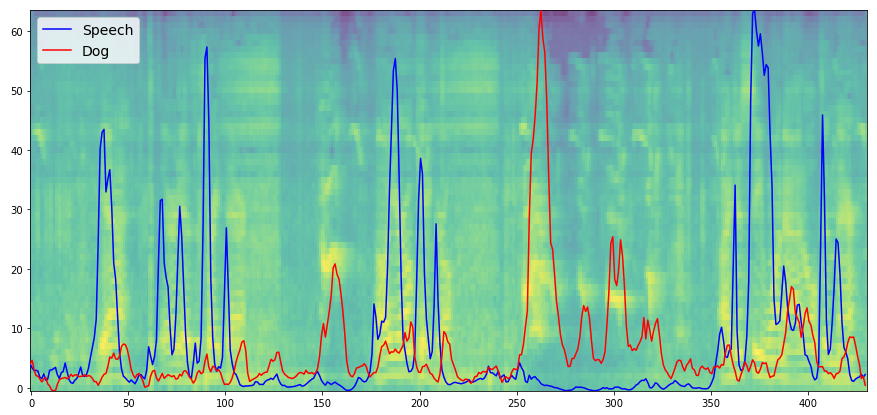

In [101]:
indice = 4
fig, axs = plt.subplots(1,1,figsize=(15,7))

# axs.imshow(featTest[indice][:,:,0] , cmap='gray', interpolation='none', alpha=0.3)
axs.imshow(featTest[indice][:,:,0], origin='lower', interpolation='none', aspect='auto', alpha=0.7)

nplots = 2

dico={0: 1, 1: 2}
dico_c={0: 'b', 1: 'r'}
dico_l={0: 'Speech', 1: 'Dog'}

# dico={0: 3}
# dico_c={0: 'b'}
# dico_l={0: 'Cat'}

fig.canvas.draw()

box = axs._position.bounds
height = box[3] / nplots

for i in range(nplots):

    tmpax = fig.add_axes([box[0], box[1], box[2], box[3]])
    tmpax.set_axis_off()
    
    proba = prob[0,:,dico[i]]
#     proba = dico_toto['Y-dDpGRPHzM0_30.000_40.000'][i]
    proba = (proba - np.min(proba[5:])) / (np.max(proba[5:]) - np.min(proba[5:]))
    print(np.max(proba))
    tmpax.plot(proba, dico_c[i], label=dico_l[i])
    tmpax.set_ylim(0, np.max(proba))
    tmpax.set_xlim(0, 431)
    plt.legend(loc=2, fontsize=14)
plt.savefig('thomas_figs/%s_100epochs_maxMIL.png'%(fichier_id))
# np.savez('thomas_probs/%s_100epochs_maxMIL_probs.npz'%(fichier_id), prob=prob[0,:,:])


In [303]:
toto = np.load('thomas_probs/%s_100epochs_maxMIL_probs.npz'%(fichier_id))
toto['prob'].shape

(431, 10)

In [352]:
np.savez('thomas_probs/%s_MEL.npz'%(fichier_id), featTest[indice][:,:,0])

In [401]:
leo_val_prob = np.load('dcase2018_task4/validation_prediction.npy')
leo_prob = np.load('dcase2018_task4/dense_noTransfer_weight_test_prediction.npy')
leo_prob[0]

array([1.23121834e-03, 1.00662676e-03, 9.67634559e-01, 7.42458031e-02,
       5.97267270e-01, 1.02405995e-02, 3.44603485e-03, 8.18447643e-06,
       1.60664167e-05, 5.55185718e-04], dtype=float32)

In [341]:
binarizer = Binarizer()
# binarizer.reset() # met tous les seuils a 0.5

binarizer.optimize(dataset.validationDataset["mel"]["output"], leo_val_prob)

binPrediction = binarizer.binarize(leo_prob)


Binarizer was already optimized. Reseting the thresholds and perform new optimization


/home/thomas/tools/miniconda2/envs/theanoEnvErebor/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ValueError: Found input variables with inconsistent numbers of samples: [435, 279]

In [354]:
binPrediction[indice]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
# ==================================================================================================================
#   STRONG ANNOTATION stage and evaluation
# ==================================================================================================================
tPrediction = model.predict(dataset.testingDataset["mel"]["input"])

encoder = Encoder()
segments = encoder.encode(tPrediction, method="threshold", smooth="smoothMovingAvg")
toEvaluate = encoder.parse(segments, dataset.testFileList)

print("perform evaluation ...")
with open("toEvaluate.csv", "w") as f:
    f.write("filename\tonset\toffset\tevent_label\n")
    f.write(toEvaluate)

perso_event_list = MetaDataContainer()
perso_event_list.load(filename="perso_eval.csv")

ref_event_list = MetaDataContainer()
ref_event_list.load(filename="../../meta/test.csv")

event_based_metric = event_based_evaluation(ref_event_list, perso_event_list)
print(event_based_metric)

print("Saving final results in final_results.txt")
with open("final_results", "w") as f:
    f.write(event_based_metric)


# multitask MIL

In [36]:
melInput = Input(dataset.getInputShape("mel"))

# ---- mel convolution part ----
mBlock1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(melInput)
mBlock1 = BatchNormalization()(mBlock1)
mBlock1 = Activation(activation="relu")(mBlock1)
mBlock1 = MaxPooling2D(pool_size=(4, 1))(mBlock1)
mBlock1 = SpatialDropout2D(0.3, data_format=K.image_data_format())(mBlock1)

mBlock2 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(mBlock1)
mBlock2 = BatchNormalization()(mBlock2)
mBlock2 = Activation(activation="relu")(mBlock2)
mBlock2 = MaxPooling2D(pool_size=(4, 1))(mBlock2)
mBlock2 = SpatialDropout2D(0.3, data_format=K.image_data_format())(mBlock2)

mBlock3 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(mBlock2)
mBlock3 = BatchNormalization()(mBlock3)
mBlock3 = Activation(activation="relu")(mBlock3)
mBlock3 = MaxPooling2D(pool_size=(4, 1))(mBlock3)
mBlock3 = SpatialDropout2D(0.3, data_format=K.image_data_format())(mBlock3)

targetShape = int(mBlock3.shape[1] * mBlock3.shape[2])
mReshape = Reshape(target_shape=(targetShape, 64))(mBlock3)

gru = Bidirectional(
    GRU(kernel_initializer='glorot_uniform', activation='tanh', recurrent_dropout=0.1, \
        dropout=0.1, units=64, return_sequences=True)
)(mReshape)

td = TimeDistributed(
    Dense(64, activation="relu"),
)(gru)

# localization head 
output_localization = TimeDistributed(
    Dense(dataset.nbClass, activation="sigmoid"), name='output_localization',
)(td)

# classification head 
gap = GlobalAveragePooling1D()(td)
gmp = GlobalMaxPooling1D()(td)
# flat_gap = Flatten()(gap)
# flat_gmp = Flatten()(gmp)

concat = Concatenate()([gap, gmp])

d = Dense(1024, activation="relu")(concat)
d = Dropout(rate=0.5)(d)

output_classif = Dense(dataset.nbClass, activation="sigmoid", name='output_classif')(d)
    

model2outputs = Model(inputs=[melInput], outputs=[output_localization, output_classif])
model2outputs.summary(line_length=100)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (None, 64, 431, 1)    0                                            
____________________________________________________________________________________________________
conv2d_19 (Conv2D)               (None, 64, 431, 64)   640         input_7[0][0]                    
____________________________________________________________________________________________________
batch_normalization_19 (BatchNor (None, 64, 431, 64)   256         conv2d_19[0][0]                  
____________________________________________________________________________________________________
activation_19 (Activation)       (None, 64, 431, 64)   0           batch_normalization_19[0][0]     
___________________________________________________________________________________________

In [37]:
epochs = 100
batch_size = 32
metrics_dico = {'output_classif': Metrics.f1, 'output_classif': Metrics.recall, 
                                            'output_classif': Metrics.precision, 'output_classif': "accuracy"}
optimizer = optimizers.Adam(lr=0.001)

model2outputs.compile(loss=[MIL_loss, "binary_crossentropy"], 
                      optimizer=optimizer,
                     metrics=metrics_dico)

(None, 10)
(None, None)


In [38]:
def lrate_schedule_fn(epoch):
    if epoch < 30:
#         print('lr: 1e-3')
        return 1e-3
    elif epoch < 50:
#         print('lr: 5e-4')
        return 1e-4
    else:
#         print('lr: 1e-5')
        return 1e-5

In [39]:
lrate_scheduler = keras.callbacks.LearningRateScheduler(lrate_schedule_fn)

history = model2outputs.fit(
    x=dataset.trainingDataset["mel"]["input"],
    y=[dataset.trainingDataset["mel"]["output"][:, np.newaxis,:], dataset.trainingDataset["mel"]["output"]], 
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(
        dataset.validationDataset["mel"]["input"],
        [dataset.validationDataset["mel"]["output"][:, np.newaxis,:], dataset.validationDataset["mel"]["output"]],
    ),
    callbacks=[lrate_scheduler],
    verbose=1
)

Train on 1768 samples, validate on 435 samples
Epoch 1/100
1768/1768 [==============================] - 75s - loss: 1.3555 - output_localization_loss: 0.9130 - output_classif_loss: 0.4425 - output_classif_acc: 0.8289 - val_loss: 1.2125 - val_output_localization_loss: 0.7910 - val_output_classif_loss: 0.4214 - val_output_classif_acc: 0.8161
Epoch 2/100
1768/1768 [==============================] - 75s - loss: 1.0786 - output_localization_loss: 0.6809 - output_classif_loss: 0.3977 - output_classif_acc: 0.8427 - val_loss: 1.1694 - val_output_localization_loss: 0.7325 - val_output_classif_loss: 0.4368 - val_output_classif_acc: 0.8106
Epoch 3/100
1768/1768 [==============================] - 75s - loss: 1.0444 - output_localization_loss: 0.6588 - output_classif_loss: 0.3856 - output_classif_acc: 0.8459 - val_loss: 1.0984 - val_output_localization_loss: 0.7073 - val_output_classif_loss: 0.3911 - val_output_classif_acc: 0.8336
Epoch 4/100
1768/1768 [==============================] - 74s - loss:

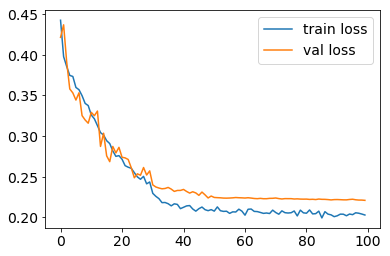

In [41]:
fig = plt.figure()
plot = fig.add_subplot(111)

plt.plot(history.history['output_classif_loss'], label='train loss')
plt.plot(history.history['val_output_classif_loss'],  label='val loss')
plt.legend(fontsize=14)

# We change the fontsize of minor ticks label 
plt.tick_params(labelsize = 14)

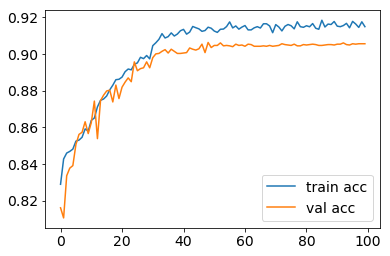

In [42]:
fig = plt.figure()
plot = fig.add_subplot(111)

plt.plot(history.history['output_classif_acc'], label='train acc')
plt.plot(history.history['val_output_classif_acc'],  label='val acc')
plt.legend(fontsize=14)

# We change the fontsize of minor ticks label 
plt.tick_params(labelsize = 14)

In [46]:
# sur la validation

binarizer = Binarizer()
binarizer.thresholds = dict()
# binarizer.reset() # met tous les seuils a 0.5
# binarizer.thresholds=[0.5]*10
for key in DCASE2018.class_correspondance:
    binarizer.thresholds[key] = 0.5
    
localization, prediction = model2outputs.predict(dataset.validationDataset["mel"]["input"])
# localization.shape, prediction.shape

In [47]:
binPrediction = binarizer.binarize(prediction)
f1_avant = f1_score(dataset.validationDataset[feat[0]]["output"], binPrediction, average=None)

binarizer.optimize(dataset.validationDataset["mel"]["output"], prediction)
binPrediction = binarizer.binarize(prediction)

f1 = f1_score(dataset.validationDataset[feat[0]]["output"], binPrediction, average=None)

In [48]:
f1_avant, f1

(array([0.73291925, 0.89328063, 0.48543689, 0.54117647, 0.48      ,
        0.496     , 0.72      , 0.51428571, 0.69565217, 0.47524752]),
 array([0.69736842, 0.88715953, 0.58823529, 0.57777778, 0.59375   ,
        0.52554745, 0.81      , 0.51428571, 0.71698113, 0.54700855]))

In [50]:
all_eval_localization, all_eval_probs  = model2outputs.predict(featTest)
all_eval_preds = binarizer.binarize(all_eval_probs)

all_eval_probs.shape, all_eval_preds.shape, all_eval_probs[4], all_eval_preds[:10]

((279, 10),
 (279, 10),
 array([0.14914757, 0.99341536, 0.05497275, 0.0022147 , 0.00791705,
        0.15415204, 0.0286268 , 0.20092851, 0.02271719, 0.02076411],
       dtype=float32),
 array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32))

In [51]:
dico_prob_curves_for_predicted_classes = get_prob_curves_for_predicted_classes(all_eval_preds, 
                                                                               all_eval_localization, 
                                                                               featTestList, 
                                                                               DCASE2018.class_correspondance_reverse)

In [54]:
save_obj(dico_prob_curves_for_predicted_classes, "eval_predictions/multitask_100epochs.pkl")

# guided backprop

In [ ]:
import sys
sys.path.append('deep-viz-keras')
from guided_backprop import GuidedBackprop
from saliency import GradientSaliency
from utils import *

In [ ]:
guided_bprop = GuidedBackprop(mo, output_index=1)